In [1]:
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import textstat
import numpy as np

In [2]:
def preprocess_text_for_bert(text):
    text = text.lower()
    text = re.sub(r"<[^>]+>", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def load_and_process_data(filepath, human_key, ai_key, n_samples_per_class=1000):
    try:
        raw_ds = load_dataset("json", data_files=filepath, split=f"train[:{n_samples_per_class*10}]")
    except Exception:
        raw_ds = load_dataset("json", data_files=filepath, split="train")

    texts, labels = [], []
    count_human, count_ai = 0, 0
    for item in raw_ds:
        human_texts = item.get(human_key, [])
        ai_texts = item.get(ai_key, [])
        if isinstance(human_texts, str): human_texts = [human_texts]
        if isinstance(ai_texts, str): ai_texts = [ai_texts]
        for text in human_texts:
            if count_human < n_samples_per_class:
                processed_text = preprocess_text_for_bert(str(text))
                if len(processed_text.split()) >= 5:
                    texts.append(processed_text); labels.append(0); count_human += 1

        for text in ai_texts:
            if count_ai < n_samples_per_class:
                processed_text = preprocess_text_for_bert(str(text))
                if len(processed_text.split()) >= 5:
                    texts.append(processed_text); labels.append(1); count_ai += 1
                    
        if count_human >= n_samples_per_class and count_ai >= n_samples_per_class: break
    print(f"From {os.path.basename(filepath)}: Loaded {count_human} human, {count_ai} AI samples.")
    return texts, labels

In [3]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [4]:
N_PER_SPLIT_ORIGINAL = 1500
N_PER_SPLIT_ELI5 = 1500
TEST_SPLIT_SIZE = 0.2
RANDOM_SEED = 42
MAX_SEQ_LENGTH = 512

texts_real_vs_gpt2, labels_real_vs_gpt2 = load_and_process_data("data/real-vs-gpt2-sentences.jsonl", human_key="real", ai_key="gpt2", n_samples_per_class=N_PER_SPLIT_ORIGINAL)
texts_hc3, labels_hc3 = load_and_process_data("data/HC3.jsonl", human_key="human_answers", ai_key="chatgpt_answers", n_samples_per_class=N_PER_SPLIT_ELI5)

all_texts = texts_real_vs_gpt2 + texts_hc3
all_labels = labels_real_vs_gpt2 + labels_hc3

print(f"\nTotal samples before shuffling: {len(all_texts)}")
print(f"Human samples: {all_labels.count(0)}, AI samples: {all_labels.count(1)}")

# Shuffle the combined dataset
combined_data = list(zip(all_texts, all_labels))
random.seed(RANDOM_SEED)
random.shuffle(combined_data)
texts, labels = zip(*combined_data)
texts = list(texts)
labels = list(labels)

print(f"Total samples after shuffling: {len(texts)}")

train_texts, test_texts, train_labels, test_labels = sk_train_test_split(texts, labels, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_SEED, stratify=labels)

print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
print(f"Train human: {train_labels.count(0)}, Train AI: {train_labels.count(1)}")
print(f"Test human: {test_labels.count(0)}, Test AI: {test_labels.count(1)}")

From real-vs-gpt2-sentences.jsonl: Loaded 1500 human, 1500 AI samples.
From HC3.jsonl: Loaded 1500 human, 1500 AI samples.

Total samples before shuffling: 6000
Human samples: 3000, AI samples: 3000
Total samples after shuffling: 6000
Training samples: 4800, Testing samples: 1200
Train human: 2400, Train AI: 2400
Test human: 600, Test AI: 600


In [5]:
train_dataset_dict = {"text": train_texts, "label": train_labels}
test_dataset_dict = {"text": test_texts, "label": test_labels}

train_dataset = Dataset.from_dict(train_dataset_dict)
test_dataset = Dataset.from_dict(test_dataset_dict)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_SEQ_LENGTH)

# Tokenize the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remove text column and set format
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"]).with_format("torch")
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["text"]).with_format("torch")

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [6]:
# Load Model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./bert_ai_detector_checkpoints",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy="steps",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="tensorboard",
    fp16=torch.cuda.is_available(),
    seed=RANDOM_SEED,
    save_total_limit=2
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.327300,0.469796,0.777500,0.814969,0.697509,0.980000
2,0.241200,0.254190,0.885833,0.887797,0.872786,0.903333
3,0.065400,0.641501,0.852500,0.868401,0.783893,0.973333


TrainOutput(global_step=900, training_loss=0.26385108417934844, metrics={'train_runtime': 392.8356, 'train_samples_per_second': 36.657, 'train_steps_per_second': 2.291, 'total_flos': 3788799197184000.0, 'train_loss': 0.26385108417934844, 'epoch': 3.0})

Training curves saved to ./training_visualizations\training_curves.png


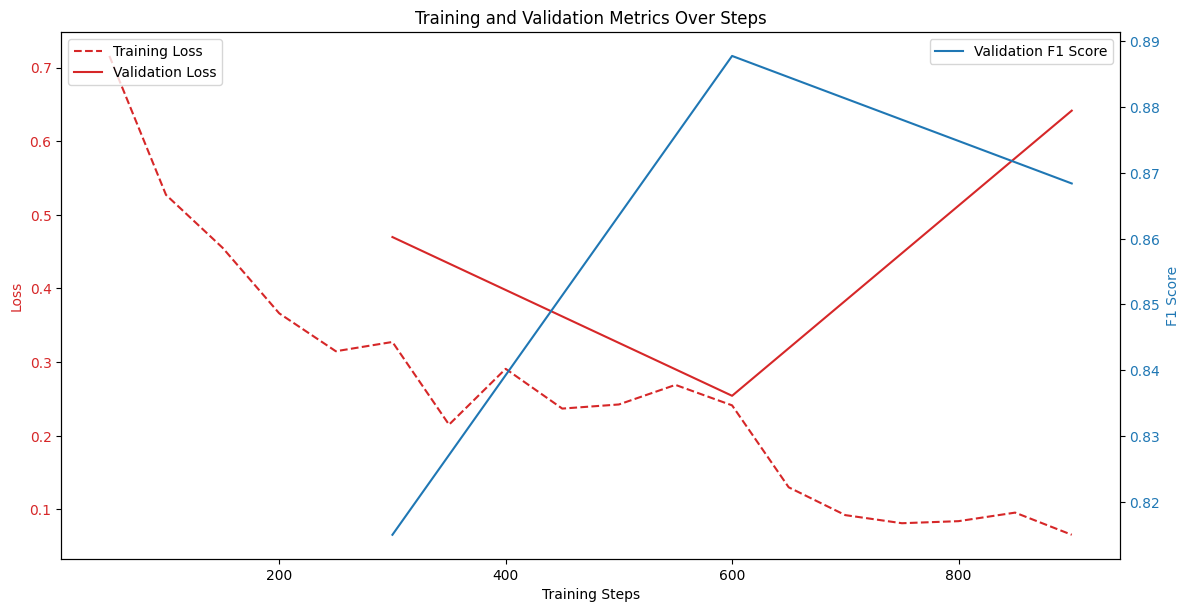

In [7]:
log_history = trainer.state.log_history

# Prepare lists for plotting
train_steps_loss = []
train_loss_values = []
eval_steps_metrics = []
eval_loss_values = []
eval_f1_values = []
eval_accuracy_values = []

for log_entry in log_history:
    if 'loss' in log_entry and 'learning_rate' in log_entry:
        train_steps_loss.append(log_entry['step'])
        train_loss_values.append(log_entry['loss'])
    elif 'eval_loss' in log_entry:
        eval_steps_metrics.append(log_entry['step']) 
        eval_loss_values.append(log_entry['eval_loss'])
        if 'eval_f1' in log_entry:
            eval_f1_values.append(log_entry['eval_f1'])
        if 'eval_accuracy' in log_entry:
            eval_accuracy_values.append(log_entry['eval_accuracy'])

output_plot_dir = "./training_visualizations"
os.makedirs(output_plot_dir, exist_ok=True)
plot_save_path = os.path.join(output_plot_dir, "training_curves.png")

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss', color=color)
if train_steps_loss and train_loss_values:
    ax1.plot(train_steps_loss, train_loss_values, color=color, linestyle='--', label='Training Loss')
if eval_steps_metrics and eval_loss_values:
    ax1.plot(eval_steps_metrics, eval_loss_values, color=color, label='Validation Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

if eval_steps_metrics and eval_f1_values:
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('F1 Score', color=color)
    ax2.plot(eval_steps_metrics, eval_f1_values, color=color, label='Validation F1 Score')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')
elif eval_steps_metrics and eval_accuracy_values:
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(eval_steps_metrics, eval_accuracy_values, color=color, label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Training and Validation Metrics Over Steps')
plt.savefig(plot_save_path)
print(f"Training curves saved to {plot_save_path}")

In [8]:
# Evaluate on local test set
print("\nEvaluating on local test set:")
eval_results = trainer.evaluate()
print(f"BERT Test Set → Acc: {eval_results['eval_accuracy']:.4f}, Prec: {eval_results['eval_precision']:.4f}, Rec: {eval_results['eval_recall']:.4f}, F1: {eval_results['eval_f1']:.4f}")

# Save the model and tokenizer
MODEL_SAVE_PATH = "./bert_ai_detector_final"
print(f"\nSaving the fine-tuned model to {MODEL_SAVE_PATH}")
trainer.save_model(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)
print(f"Model and tokenizer saved to {MODEL_SAVE_PATH}")


Evaluating on local test set:


BERT Test Set → Acc: 0.8858, Prec: 0.8728, Rec: 0.9033, F1: 0.8878

Saving the fine-tuned model to ./bert_ai_detector_final
Model and tokenizer saved to ./bert_ai_detector_final
